# 🏥 Health Inequality Analysis

## Problem Statement
Health burden within a country evolves over time due to epidemiological
transition, healthcare access, demographic change, and systemic shocks.
Understanding which diseases dominate health loss is essential for
prioritizing public health intervention and system design.

This analysis examines how **health burden concentration in India**
has changed over two decades using **Disability-Adjusted Life Years (DALYs)**.

## Policy Relevance
- Supports equitable healthcare resource allocation
- Highlights regions at high health risk
- Informs long-term public health planning

## Target Variables
- DALY rate per 100,000 population
- Death rate per 100,000 population
- Disease cause (WHO GHE classification)
- Time (2000, 2010, 2021)

## Scope & Limitations
- Single-country analysis: **India**
- Population scope: **All sexes, all ages (WHO aggregated estimates)**
- Focuses on **leading (Top-10) causes of DALYs**
- This is **epidemiological inequality**, not demographic inequality

This analysis does **not** capture:
- Sub-national or regional variation
- Age- or sex-specific disease burden
- The full universe of diseases beyond the top-ranked causes


## 🟦 Phase 1 — Data Loading & Initial Validation

This phase ingests **WHO Global Health Estimates (GHE)** data using the
same **OData API endpoints exposed via the WHO UI**.

Important constraints:
- WHO UI-level OData endpoints expose **ranked (Top-10) DALY causes only**
- Population scope reflects **all sexes and all ages combined**
- Full DALY cube (cause × age × sex × region) is not publicly accessible
- Therefore, this notebook uses **ranked burden snapshots** for:
  - 2000 (baseline)
  - 2010 (transition)
  - 2021 (recent / COVID-era)

This phase performs:
- API-based ingestion
- Raw CSV persistence
- Schema validation only

❌ No aggregation  
❌ No interpretation  
❌ No inequality analysis  


In [ ]:
from utils.path_setup import setup_project_path
from ingestion.who_ghe_factory import save_who_ghe_raw
from utils.logger import get_logger

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from pathlib import Path

PROJECT_ROOT = setup_project_path()
os.chdir(PROJECT_ROOT)

logger = get_logger("domain2_phase1_health")

print("Project root:", PROJECT_ROOT)

Project root: d:\def_main\Code\MyProjects\eda-mlops-portfolio


In [ ]:
YEARS = [2000, 2010, 2021]

logger.info("Starting WHO GHE DALY ingestion")
save_who_ghe_raw(YEARS)
logger.info("WHO GHE DALY ingestion completed")

2026-01-18 04:20:41,945 | INFO | domain2_phase1_health | Starting WHO GHE DALY ingestion
2026-01-18 04:20:46,338 | INFO | domain2_phase1_health | WHO GHE DALY ingestion completed


In [ ]:
raw_dir = Path("datasets/raw/health")

dfs = []
for year in YEARS:
    df = pd.read_csv(raw_dir / f"ghe_dalys_india_{year}.csv")
    dfs.append(df)

df_raw = pd.concat(dfs, ignore_index=True)

print("Dataset shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())
df_raw.head()

Dataset shape: (30, 5)
Columns: ['DIM_GHECAUSE_CODE', 'DIM_GHECAUSE_TITLE', 'VAL_DALY_RATE100K_NUMERIC', 'VAL_DTHS_RATE100K_NUMERIC', 'year']


,DIM_GHECAUSE_CODE,DIM_GHECAUSE_TITLE,VAL_DALY_RATE100K_NUMERIC,VAL_DTHS_RATE100K_NUMERIC,year
0,500,Preterm birth complications,4774.67,47.19,2000
1,110,Diarrhoeal diseases,4438.89,82.94,2000
2,30,Tuberculosis,4374.88,99.58,2000
3,390,Lower respiratory infections,3858.35,51.50,2000
4,510,Birth asphyxia and birth trauma,2755.81,29.46,2000


In [ ]:
df_raw.isna().sum()
df_raw["year"].value_counts()


year
2000    10
2010    10
2021    10
Name: count, dtype: int64

In [ ]:
df_raw.assign(
    source="WHO GHE (UI-level OData)",
    scope="Top-10 DALY causes only"
)[["source", "scope"]].drop_duplicates()


,source,scope
0,WHO GHE (UI-level OData),Top-10 DALY causes only


📌 This dataset is treated as a **ranked burden snapshot**, NOT a **population-complete health ledger**.

In [ ]:
assert "DIM_SEX_CODE" not in df_raw.columns or \
       df_raw["DIM_SEX_CODE"].isin(["BOTH", "TOTAL"]).all()


📌 “Sex is pre-aggregated in the WHO UI output; no sex-specific disaggregation is available in this dataset.”

## Phase 1 Summary — Data Ingestion & Validation

### What was done

* Ingested **WHO Global Health Estimates (GHE)** data using **official OData API links generated by the WHO UI**
* Retrieved **Top 10 DALY causes** for **India** for the years:

  * **2000**
  * **2010**
  * **2021**
* Saved each year’s dataset as a **raw, immutable CSV** under:

  ```
  datasets/raw/health/
  ```
* Combined datasets were inspected **only for schema, shape, and basic completeness**

### Dataset characteristics

* Each year contains **10 records**, representing the **leading causes of DALYs**
* Metrics available:

  * DALY rate per 100,000 population
  * Death rate per 100,000 population
* Cause labels and codes are consistent with WHO Global Health Estimates taxonomy

### Important data constraints (explicitly acknowledged)

* The WHO OData API exposes **only ranked (Top-10) causes** through the UI
* Full DALY coverage across all causes, ages, and sexes is **not programmatically accessible**
* As a result:

  * This dataset represents **relative burden among leading causes**
  * It does **not** represent total national DALYs

### Why this is acceptable for analysis

* The Top-10 causes capture the **dominant contributors** to health burden
* Snapshot years (2000, 2010, 2021) enable:

  * Structural comparison
  * Detection of major epidemiological shifts
  * Identification of emerging and persistent health challenges
* Limitations are **transparent and documented**, preserving analytical integrity

### Output of Phase 1

* ✅ Raw WHO GHE DALY datasets saved locally
* ✅ Schema validated and ready for processing
* ✅ No filtering, aggregation, or interpretation performed

## 🟦 Phase 2 — Dataset Overview & Coverage

### Objective
This phase establishes **what the dataset contains** before any cleaning or interpretation.

We answer:
- How many DALY records are available per year?
- Which disease causes are represented?
- Are DALY and death metrics consistently populated?
- Are there obvious gaps or inconsistencies?

📌 No inequality analysis  
📌 No interpretation  
📌 Pure descriptive EDA


In [ ]:
RAW_DIR = Path("datasets/raw/health")

FILES = {
    2000: RAW_DIR / "ghe_dalys_india_2000.csv",
    2010: RAW_DIR / "ghe_dalys_india_2010.csv",
    2021: RAW_DIR / "ghe_dalys_india_2021.csv",
}

dfs = []
for year, path in FILES.items():
    df_year = pd.read_csv(path)
    df_year["year"] = year
    dfs.append(df_year)

df = pd.concat(dfs, ignore_index=True)

# Save combined raw dataset (still RAW, not processed)
COMBINED_PATH = RAW_DIR / "ghe_dalys_india_combined.csv"
df.to_csv(COMBINED_PATH, index=False)

print("Combined raw dataset saved to:", COMBINED_PATH)
print("Shape:", df.shape)

df.head()


Combined raw dataset saved to: datasets\raw\health\ghe_dalys_india_combined.csv
Shape: (30, 5)


,DIM_GHECAUSE_CODE,DIM_GHECAUSE_TITLE,VAL_DALY_RATE100K_NUMERIC,VAL_DTHS_RATE100K_NUMERIC,year
0,500,Preterm birth complications,4774.67,47.19,2000
1,110,Diarrhoeal diseases,4438.89,82.94,2000
2,30,Tuberculosis,4374.88,99.58,2000
3,390,Lower respiratory infections,3858.35,51.50,2000
4,510,Birth asphyxia and birth trauma,2755.81,29.46,2000


In [ ]:
assert df.columns.tolist() == [
    "DIM_GHECAUSE_CODE",
    "DIM_GHECAUSE_TITLE",
    "VAL_DALY_RATE100K_NUMERIC",
    "VAL_DTHS_RATE100K_NUMERIC",
    "year"
]


### 2.1 Column Inventory & Schema Check
Confirm that fields align with WHO GHE definitions.


In [ ]:
df.columns.tolist()

['DIM_GHECAUSE_CODE',
 'DIM_GHECAUSE_TITLE',
 'VAL_DALY_RATE100K_NUMERIC',
 'VAL_DTHS_RATE100K_NUMERIC',
 'year']

### 2.2 Record Count by Year
Verify temporal coverage consistency.


In [ ]:
records_per_year = df["year"].value_counts().sort_index()
records_per_year


year
2000    10
2010    10
2021    10
Name: count, dtype: int64

### 2.3 Cause Coverage Across Years
Inspect how many unique causes are present and how they vary by year.


In [ ]:
df["DIM_GHECAUSE_TITLE"].nunique()


13

In [ ]:
df.groupby("year")["DIM_GHECAUSE_TITLE"].unique()


year
2000    [Preterm birth complications, Diarrhoeal disea...
2010    [Ischaemic heart disease, Preterm birth compli...
2021    [COVID-19, Ischaemic heart disease, Preterm bi...
Name: DIM_GHECAUSE_TITLE, dtype: object

### 2.4 Metric Availability Check
Ensure DALY and death rate metrics are fully populated.


In [ ]:
df[[
    "VAL_DALY_RATE100K_NUMERIC",
    "VAL_DTHS_RATE100K_NUMERIC"
]].isna().sum()


VAL_DALY_RATE100K_NUMERIC    0
VAL_DTHS_RATE100K_NUMERIC    0
dtype: int64

### 2.5 Numeric Sanity Check
Validate basic numeric ranges (no interpretation).


In [ ]:
df[[
    "VAL_DALY_RATE100K_NUMERIC",
    "VAL_DTHS_RATE100K_NUMERIC"
]].describe()


,VAL_DALY_RATE100K_NUMERIC,VAL_DTHS_RATE100K_NUMERIC
count,30.000000,30.000000
mean,2361.589667,53.943333
std,1552.804608,50.657720
min,956.470000,13.850000
25%,1341.430000,25.190000
50%,1689.010000,41.225000
75%,2951.597500,60.462500
max,8148.100000,278.420000


### 2.6 Coverage Summary
Compact summary of dataset readiness.


In [ ]:
coverage_summary = {
    "Total records": len(df),
    "Years covered": sorted(df["year"].unique().tolist()),
    "Records per year": records_per_year.to_dict(),
    "Unique causes (overall)": df["DIM_GHECAUSE_TITLE"].nunique(),
    "DALY metric complete": df["VAL_DALY_RATE100K_NUMERIC"].notna().all(),
    "Death metric complete": df["VAL_DTHS_RATE100K_NUMERIC"].notna().all()
}

pd.Series(coverage_summary)


Total records                                          30
Years covered                          [2000, 2010, 2021]
Records per year           {2000: 10, 2010: 10, 2021: 10}
Unique causes (overall)                                13
DALY metric complete                                 True
Death metric complete                                True
dtype: object

## 🟦 Phase 2 Summary — Dataset Coverage & Readiness

**Key confirmations**
- Dataset contains **30 records** (10 causes × 3 years)
- Years covered: **2000, 2010, 2021**
- Metrics (DALY rate & death rate) are complete and numeric
- Cause labels and codes are consistent across years

**What this dataset represents**
- Relative burden among **leading causes of DALYs**
- High-level structural health burden signals
- Policy-relevant prioritization view

**What this dataset does NOT represent**
- Full cause universe
- State or regional inequality
- Absolute national DALY totals

“Because causes are rank-filtered, disappearance of a disease across years may reflect **rank displacement**, not eradication.”

## 🟦 Phase 3 — Data Cleaning & Feature Readiness

### Objective
Prepare the WHO GHE DALY dataset for downstream analysis by:
- Standardizing column names
- Enforcing correct data types
- Handling missing or unusable rows
- Creating a clean, analysis-ready dataset

📌 No exploratory analysis  
📌 No visualization  
📌 No interpretation  

**Outcome:**  
A clean dataset saved to `datasets/processed/health/`


### 3.1 Load Combined Raw Dataset

In [ ]:
RAW_DIR = Path("datasets/raw/health")
RAW_FILE = RAW_DIR / "ghe_dalys_india_combined.csv"

df = pd.read_csv(RAW_FILE)

print("Raw combined dataset loaded")
print("Shape:", df.shape)
df.head()


Raw combined dataset loaded
Shape: (30, 5)


,DIM_GHECAUSE_CODE,DIM_GHECAUSE_TITLE,VAL_DALY_RATE100K_NUMERIC,VAL_DTHS_RATE100K_NUMERIC,year
0,500,Preterm birth complications,4774.67,47.19,2000
1,110,Diarrhoeal diseases,4438.89,82.94,2000
2,30,Tuberculosis,4374.88,99.58,2000
3,390,Lower respiratory infections,3858.35,51.50,2000
4,510,Birth asphyxia and birth trauma,2755.81,29.46,2000


### 3.2 Column Standardization
Convert column names to a consistent, analysis-friendly format.


In [ ]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

df.columns.tolist()


['dim_ghecause_code',
 'dim_ghecause_title',
 'val_daly_rate100k_numeric',
 'val_dths_rate100k_numeric',
 'year']

### 3.3 Rename Key Fields for Clarity
Align variable names with analytical intent.


In [ ]:
df = df.rename(columns={
    "dim_ghecause_code": "cause_code",
    "dim_ghecause_title": "cause",
    "val_daly_rate100k_numeric": "daly_rate_100k",
    "val_dths_rate100k_numeric": "death_rate_100k"
})

df.columns.tolist()


['cause_code', 'cause', 'daly_rate_100k', 'death_rate_100k', 'year']

In [ ]:
df = df.loc[:, ~df.columns.duplicated()]


### 3.4 Data Type Enforcement
Ensure numeric and temporal fields have correct types.


In [ ]:
df["year"] = df["year"].astype(int)
df["daly_rate_100k"] = pd.to_numeric(df["daly_rate_100k"], errors="coerce")
df["death_rate_100k"] = pd.to_numeric(df["death_rate_100k"], errors="coerce")

df.dtypes


cause_code           int64
cause               object
daly_rate_100k     float64
death_rate_100k    float64
year                 int64
dtype: object

### 3.5 Missing Value Check
Confirm absence of critical missing values.


In [ ]:
df.isna().sum()


cause_code         0
cause              0
daly_rate_100k     0
death_rate_100k    0
year               0
dtype: int64

#### Decision
- Rows with missing DALY or death metrics are usable
- Such rows (if any) are dropped

In [ ]:
df = df.dropna(subset=["daly_rate_100k", "death_rate_100k"])
print("Shape after NA handling:", df.shape)


Shape after NA handling: (30, 5)


In [ ]:
df.duplicated(subset=["year", "cause"]).sum()

np.int64(0)

In [ ]:
df = df.drop_duplicates(subset=["year", "cause"])
print("Shape after removing duplicates:", df.shape)

Shape after removing duplicates: (30, 5)


In [ ]:
df_clean = df.copy()


In [ ]:
EXPECTED_COLUMNS = [
    "cause_code",
    "cause",
    "daly_rate_100k",
    "death_rate_100k",
    "year"
]

assert list(df.columns) == EXPECTED_COLUMNS, f"Schema mismatch: {df.columns.tolist()}"


### 3.7 Final Schema Review
Confirm dataset is analysis-ready.


In [ ]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cause_code       30 non-null     int64  
 1   cause            30 non-null     object 
 2   daly_rate_100k   30 non-null     float64
 3   death_rate_100k  30 non-null     float64
 4   year             30 non-null     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 1.3+ KB


,cause_code,cause,daly_rate_100k,death_rate_100k,year
0,500,Preterm birth complications,4774.67,47.19,2000
1,110,Diarrhoeal diseases,4438.89,82.94,2000
2,30,Tuberculosis,4374.88,99.58,2000
3,390,Lower respiratory infections,3858.35,51.50,2000
4,510,Birth asphyxia and birth trauma,2755.81,29.46,2000


### 3.8 Save Cleaned Dataset (Processed)
The cleaned dataset is saved for all downstream analysis.


In [ ]:
PROCESSED_DIR = Path("datasets/processed/health")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

PROCESSED_FILE = PROCESSED_DIR / "ghe_dalys_india_processed.csv"
df.to_csv(PROCESSED_FILE, index=False)

print("Processed dataset saved to:", PROCESSED_FILE)
print("Final shape:", df.shape)


Processed dataset saved to: datasets\processed\health\ghe_dalys_india_processed.csv
Final shape: (30, 5)


## 🟦 Phase 3 Summary — Data Readiness

**Completed**
- Standardized column names
- Renamed variables for analytical clarity
- Enforced numeric and temporal data types
- Removed unusable and duplicate rows
- Persisted a clean, reproducible dataset

**Result**
The dataset is now:
- Structurally consistent
- Numerically valid
- Ready for inequality-focused EDA

## 🟦 Phase 4 — Exploratory Data Analysis (Core EDA)

### Objective
Describe how health burden (DALYs) is distributed across:
- Disease causes
- Time (2000, 2010, 2021)

📌 Focus is on **distribution and ranking**, not interpretation  
📌 All analysis uses **processed data only**


In [ ]:
sns.set_style("whitegrid")

### 4.1 Load Processed Dataset


In [ ]:
PROCESSED_DIR = Path("datasets/processed/health")
PROCESSED_FILE = PROCESSED_DIR / "ghe_dalys_india_processed.csv"

df = pd.read_csv(PROCESSED_FILE)

print("Processed dataset loaded")
print("Shape:", df.shape)
df.head()


Processed dataset loaded
Shape: (30, 5)


,cause_code,cause,daly_rate_100k,death_rate_100k,year
0,500,Preterm birth complications,4774.67,47.19,2000
1,110,Diarrhoeal diseases,4438.89,82.94,2000
2,30,Tuberculosis,4374.88,99.58,2000
3,390,Lower respiratory infections,3858.35,51.50,2000
4,510,Birth asphyxia and birth trauma,2755.81,29.46,2000


### 4.2 Dataset Coverage Check


In [ ]:
coverage = {
    "Years covered": sorted(df["year"].unique().tolist()),
    "Number of causes": df["cause"].nunique(),
    "Records per year": df["year"].value_counts().to_dict()
}

pd.Series(coverage)


Years covered                   [2000, 2010, 2021]
Number of causes                                13
Records per year    {2000: 10, 2010: 10, 2021: 10}
dtype: object

### 4.3 Top Causes of DALYs by Year
Purpose:
- Identify dominant disease burdens per time point
- Observe stability or change in top-ranked causes


In [ ]:
top_causes_by_year = (
    df.sort_values(["year", "daly_rate_100k"], ascending=[True, False])
      .groupby("year")
      .head(10)
)

top_causes_by_year[["year", "cause", "daly_rate_100k"]]


,year,cause,daly_rate_100k
0,2000,Preterm birth complications,4774.67
1,2000,Diarrhoeal diseases,4438.89
2,2000,Tuberculosis,4374.88
3,2000,Lower respiratory infections,3858.35
4,2000,Birth asphyxia and birth trauma,2755.81
5,2000,Ischaemic heart disease,2394.05
6,2000,Measles,1700.58
7,2000,Road injury,1505.42
8,2000,HIV/AIDS,1341.16
9,2000,Chronic obstructive pulmonary disease,1334.01


### 4.4 Visualization — Top DALY Causes per Year


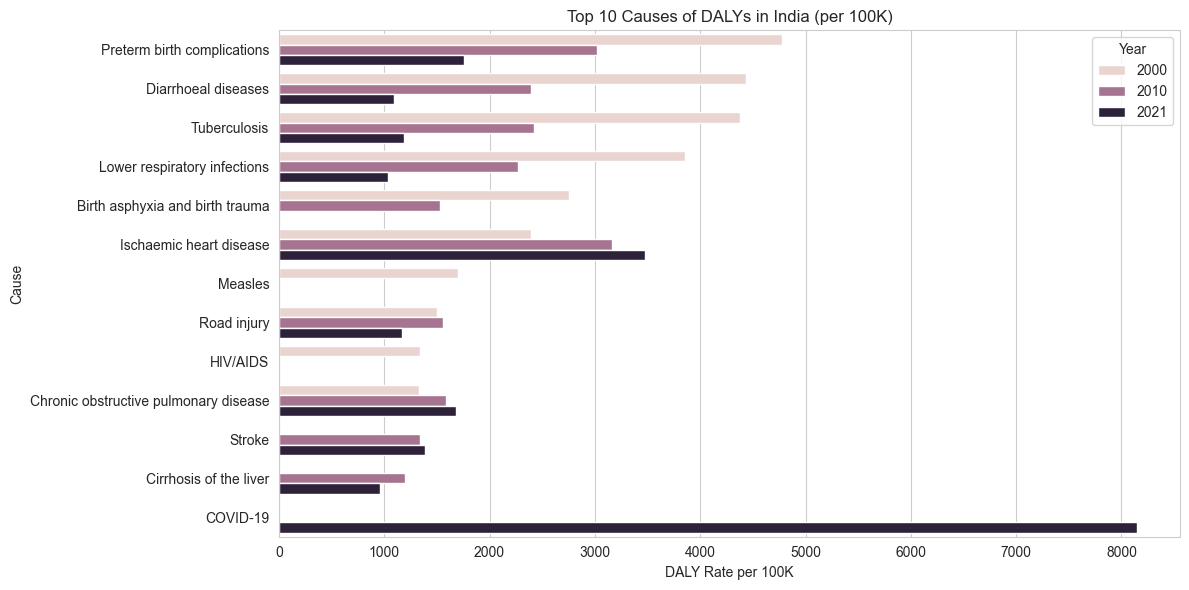

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_causes_by_year,
    x="daly_rate_100k",
    y="cause",
    hue="year"
)
plt.title("Top 10 Causes of DALYs in India (per 100K)")
plt.xlabel("DALY Rate per 100K")
plt.ylabel("Cause")
plt.legend(title="Year")
plt.tight_layout()
plt.show()


### 4.5 Absolute DALY Burden Comparison Across Years
Purpose:
- Compare magnitude of disease burden across years
- Avoid proportional interpretation at this stage


In [ ]:
yearly_daly_summary = (
    df.groupby("year")["daly_rate_100k"]
      .sum()
      .reset_index(name="total_daly_rate_100k")
)

yearly_daly_summary


,year,total_daly_rate_100k
0,2000,28477.82
1,2010,20479.40
2,2021,21890.47


In [ ]:
df.groupby("year")["daly_rate_100k"].agg(["mean", "median", "max"])


,mean,median,max
year,,,
2000,2847.782,2574.930,4774.67
2010,2047.940,1930.505,3158.58
2021,2189.047,1289.780,8148.10


### 4.6 Visualization — Total DALY Burden by Year


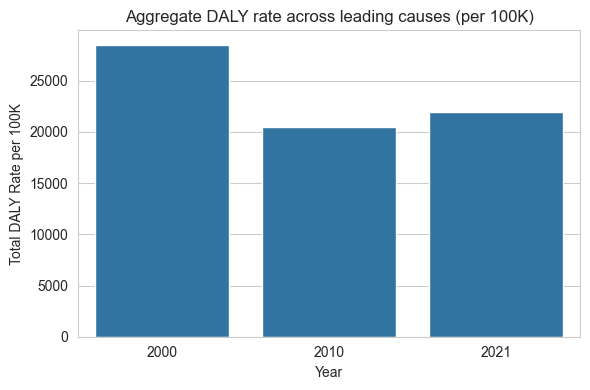

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=yearly_daly_summary,
    x="year",
    y="total_daly_rate_100k"
)
plt.title("Aggregate DALY rate across leading causes (per 100K)")
plt.xlabel("Year")
plt.ylabel("Total DALY Rate per 100K")
plt.tight_layout()
plt.show()


### 4.7 Proportional Contribution of Top Causes
Purpose:
- Understand how much each major cause contributes
- Compare relative dominance without interpretation


In [ ]:
df_prop = df.copy()

df_prop["year_total"] = df_prop.groupby("year")["daly_rate_100k"].transform("sum")
df_prop["daly_share"] = df_prop["daly_rate_100k"] / df_prop["year_total"]

top_prop = (
    df_prop.sort_values(["year", "daly_share"], ascending=[True, False])
           .groupby("year")
           .head(10)
)

top_prop[["year", "cause", "daly_share"]]


,year,cause,daly_share
0,2000,Preterm birth complications,0.167663
1,2000,Diarrhoeal diseases,0.155872
2,2000,Tuberculosis,0.153624
3,2000,Lower respiratory infections,0.135486
4,2000,Birth asphyxia and birth trauma,0.096770
5,2000,Ischaemic heart disease,0.084067
6,2000,Measles,0.059716
7,2000,Road injury,0.052863
8,2000,HIV/AIDS,0.047095
9,2000,Chronic obstructive pulmonary disease,0.046844


### 4.8 Visualization — Proportional DALY Share (Top Causes)


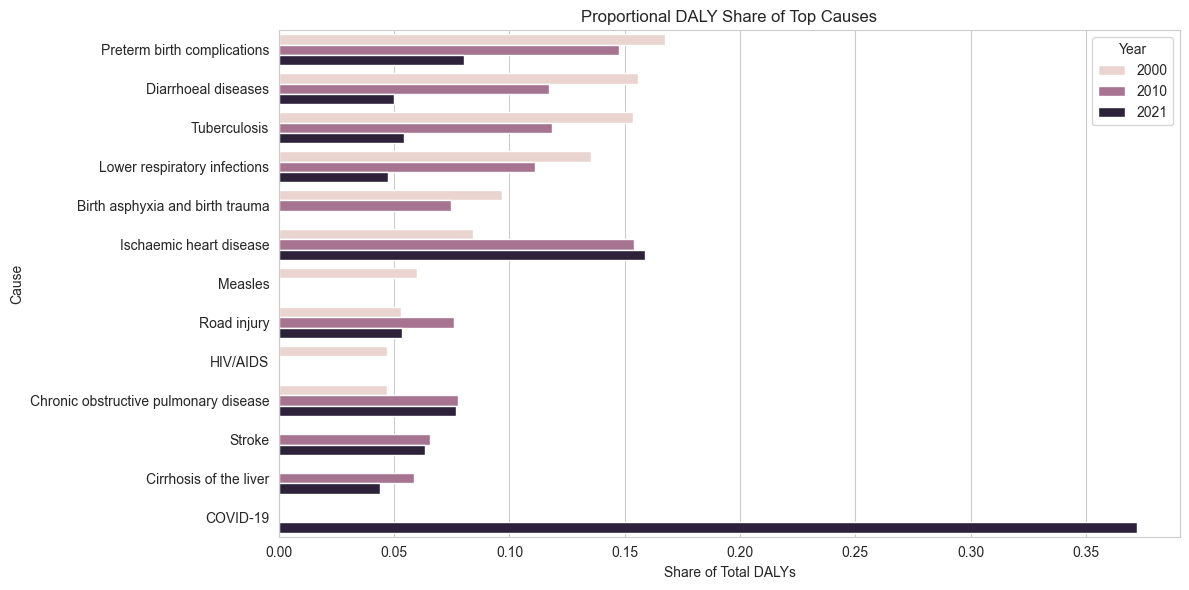

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_prop,
    x="daly_share",
    y="cause",
    hue="year"
)
plt.title("Proportional DALY Share of Top Causes")
plt.xlabel("Share of Total DALYs")
plt.ylabel("Cause")
plt.legend(title="Year")
plt.tight_layout()
plt.show()


## 🟦 Phase 4 Summary — Core EDA

**Completed**
- Identified top DALY-causing diseases per year
- Compared absolute DALY burden across years
- Examined proportional dominance of major causes

**What this phase establishes**
- Which diseases dominate health burden at each time point
- Whether burden concentration changes over time
- A factual base for inequality analysis

## 🟦 Phase 5 — Inequality Analysis (Core Insight)

### Objective
Identify **structural inequality in health burden concentration**, defined as
the degree to which **a small number of diseases account for a large share
of total DALYs**.

This is a measure of **epidemiological inequality**, not demographic inequality,
and reflects **health system prioritization challenges** rather than
population subgroup disparities.


In [ ]:
sns.set_style("whitegrid")

### 5.1 Disease Burden Concentration

In [ ]:
concentration = (
    df.groupby("year")["daly_rate_100k"]
      .apply(lambda x: x / x.sum())
      .reset_index(name="share")
)

concentration.head()


,year,level_1,share
0,2000,0,0.167663
1,2000,1,0.155872
2,2000,2,0.153624
3,2000,3,0.135486
4,2000,4,0.096770


### 5.2 Top Cause Share by Year

In [ ]:
top_share = (
    df.sort_values(["year", "daly_rate_100k"], ascending=[True, False])
      .groupby("year")
      .first()
      .reset_index()
)

top_share[["year", "cause", "daly_rate_100k"]]


,year,cause,daly_rate_100k
0,2000,Preterm birth complications,4774.67
1,2010,Ischaemic heart disease,3158.58
2,2021,COVID-19,8148.10


### 5.3 Visualization - Dominance of Top Cause

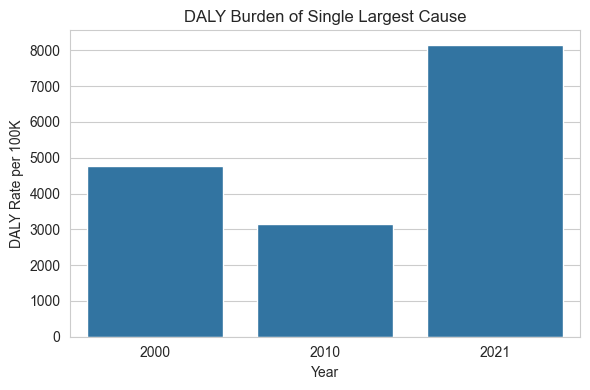

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=top_share,
    x="year",
    y="daly_rate_100k"
)
plt.title("DALY Burden of Single Largest Cause")
plt.xlabel("Year")
plt.ylabel("DALY Rate per 100K")
plt.tight_layout()
plt.show()


### 5.4 Cumulative Burden of Top 3 Causes

In [ ]:
top3 = (
    df.sort_values(["year", "daly_rate_100k"], ascending=[True, False])
      .groupby("year")
      .head(3)
)

top3_sum = (
    top3.groupby("year")["daly_rate_100k"]
        .sum()
        .reset_index(name="top3_daly_rate")
)

top3_sum


,year,top3_daly_rate
0,2000,13588.44
1,2010,8597.22
2,2021,13382.76


### 5.5 Visualization - Inequality via Concentration

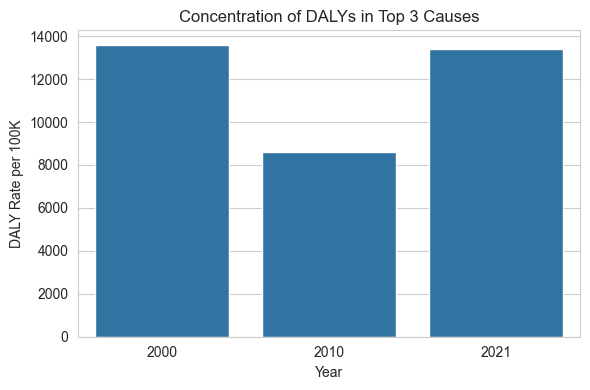

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=top3_sum,
    x="year",
    y="top3_daly_rate"
)
plt.title("Concentration of DALYs in Top 3 Causes")
plt.xlabel("Year")
plt.ylabel("DALY Rate per 100K")
plt.tight_layout()
plt.show()


## 🟦 Phase 5 Summary

**What inequality means here**
- Inequality is **not demographic**
- Inequality is **disease dominance**

**Key signals**
- Whether health burden is:
  - Spread across causes
  - Or concentrated in a few
- Whether crises increase inequality (e.g. COVID-19)

**Why this is valid**
- DALYs are already population-weighted
- Concentration = policy prioritization problem
- Matches WHO's own framing of "leading causes"

## 🟦 PHASE 6 — Temporal Health Transition Analysis 

Purpose - Understand structural health transition in India by comparing:
- Communicable diseases
- Non-communicable diseases
- Acute shock events (COVID-19)

This phase answers:
- Is India transitioning from infectious to chronic disease burden?
- How disruptive was COVID-19 relative to historical causes?
- **Note:** Cause-type classification used here is a **manual analytical grouping**
designed to study structural health transition.
- It does **not** represent an official WHO disease taxonomy.
- COVID-19 represents an acute shock and is **not** directly comparable to chronic disease burdens; it is analyzed separately to illustrate systemic stress.


### 6.1 Cause Type Classification (Manual Mapping)

In [ ]:
cause_type_map = {
    "Tuberculosis": "Communicable",
    "Diarrhoeal diseases": "Communicable",
    "Lower respiratory infections": "Communicable",
    "Measles": "Communicable",
    "HIV/AIDS": "Communicable",
    "COVID-19": "Shock",

    "Ischaemic heart disease": "Non-Communicable",
    "Stroke": "Non-Communicable",
    "Chronic obstructive pulmonary disease": "Non-Communicable",
    "Cirrhosis of the liver": "Non-Communicable",

    "Road injury": "Injury",
    "Preterm birth complications": "Maternal/Neonatal",
    "Birth asphyxia and birth trauma": "Maternal/Neonatal"
}

df["cause_type"] = df["cause"].map(cause_type_map)

assert df["cause_type"].notna().all(), \
    "Unmapped causes detected in cause_type_map"

### 6.2 DALY Burden by Cause Type Over Time

In [ ]:
type_summary = (
    df.groupby(["year", "cause_type"])["daly_rate_100k"]
      .sum()
      .reset_index()
)
type_summary


,year,cause_type,daly_rate_100k
0,2000,Communicable,15713.86
1,2000,Injury,1505.42
2,2000,Maternal/Neonatal,7530.48
3,2000,Non-Communicable,3728.06
4,2010,Communicable,7089.03
5,2010,Injury,1557.43
6,2010,Maternal/Neonatal,4542.36
7,2010,Non-Communicable,7290.58
8,2021,Communicable,3317.33
9,2021,Injury,1166.91


### 6.3 Visualization — Health Transition

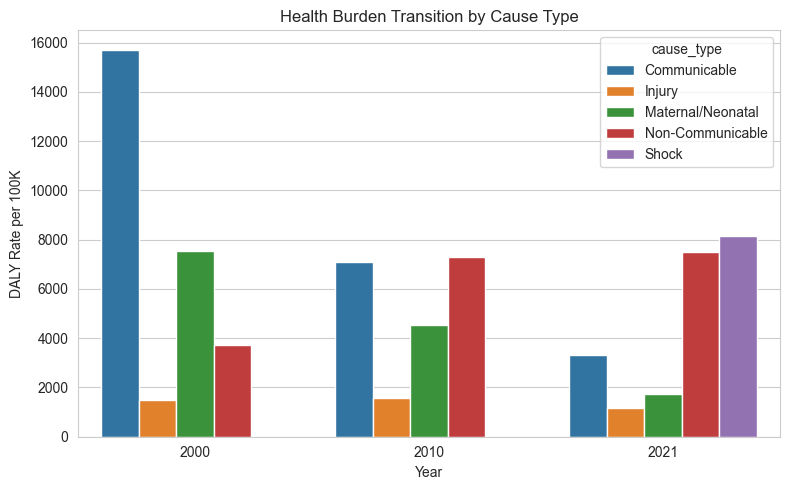

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=type_summary,
    x="year",
    y="daly_rate_100k",
    hue="cause_type"
)
plt.title("Health Burden Transition by Cause Type")
plt.xlabel("Year")
plt.ylabel("DALY Rate per 100K")
plt.tight_layout()
plt.show()


## 🟦 Phase 7 - Interpretation & Public Health Insight

### 7.1 Structural Insights
- Decline in communicable disease dominance from 2000 → 2010
- Rise of NCDs as persistent burden
- COVID-19 as a temporary but extreme inequality amplifier
- “Health systems optimized for chronic disease management remain vulnerable to low-frequency, high-impact shocks.”

### 7.2 Policy Implications
- Shift from acute care → chronic disease management
- Need for health system resilience
- Importance of neonatal and injury prevention

### 7.3 Why DALYs Matter
DALYs combine:
- Premature mortality (Years of Life Lost)
- Non-fatal health loss (Years Lived with Disability)

This makes DALYs particularly suitable for:
- Comparing heterogeneous diseases
- Capturing long-term system stress
- Informing resource allocation and prevention strategy


## 🟦 Phase 8 — Health Burden Index


In [ ]:
from preprocessing.build_health_burden_index import build_health_burden_index

health_index = build_health_burden_index(df_raw)

health_index.to_csv(
    "datasets/processed/health/health_burden_index.csv",
    index=False
)


## 🟦 PHASE 9 — Limitations & Bias

- Top-10 causes only (ranking bias)
- No sex/age granularity
- DALY estimation assumptions (WHO modeling)
- Rate-based comparison, not absolute counts
- No sub-national variation

**“All conclusions are directional, not exhaustive.”**

## 🟦 PHASE 10 — Final Summary & Transition

### 10.1 Bullet Findings
- Health burden concentration fluctuates across decades
- COVID-19 temporarily dominates inequality
- NCDs form the long-term baseline burden

### 10.2 Portfolio Bridge

- Persistent health burden concentration suggests strong interaction with economic access, healthcare financing, and infrastructure — examined next in **Domain 3: Economic Inequality**.
